# [예제](https://github.com/WillKoehrsen/Data-Analysis/blob/master/over_vs_under/Over%20vs%20Under%20Fitting%20Example.ipynb)

In [19]:
# Numpy and pandas as usual
import numpy as np
import pandas as pd

# Scikit-Learn for fitting models
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error

# For plotting in the notebook
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

# Default parameters for plots
matplotlib.rcParams['font.size'] = 12
matplotlib.rcParams['figure.titlesize'] = 16
matplotlib.rcParams['figure.figsize'] = [9, 7]

## Training

### Create data

In [2]:
# Set the random seed for reproducible results
np.random.seed(42)

# "True" generating function representing a process in real life
def true_gen(x):
    y = np.sin(1.2 * x * np.pi)
    return(y)

# x values and y value with a small amount of random noise
x = np.sort(np.random.rand(120))
y = true_gen(x) + 0.1 * np.random.randn(len(x))

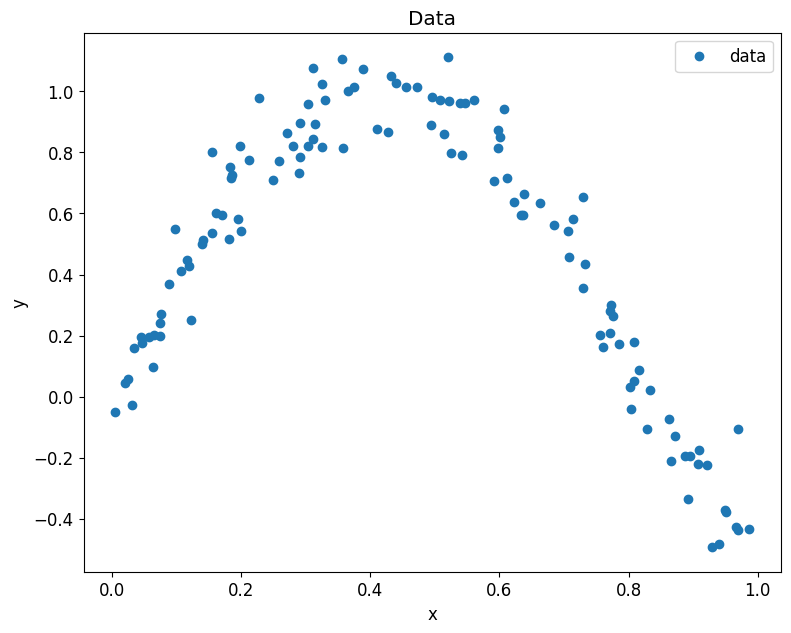

In [6]:
# Visualize observations and true curve
plt.plot(x, y, 'o', label = 'data')

plt.legend()
plt.xlabel('x');
plt.ylabel('y');
plt.title('Data');

### Training and Testing Sets

In [7]:
# Random indices for creating training and testing sets
random_ind = np.random.choice(list(range(120)), size = 120, replace=False)
xt = x[random_ind]
yt = y[random_ind]

# Training and testing observations
train = xt[:int(0.7 * len(x))]
test = xt[int(0.7 * len(x)):]

y_train = yt[:int(0.7 * len(y))]
y_test = yt[int(0.7 * len(y)):]

# Model the true curve
x_linspace = np.linspace(0, 1, 1000)
y_true = true_gen(x_linspace)

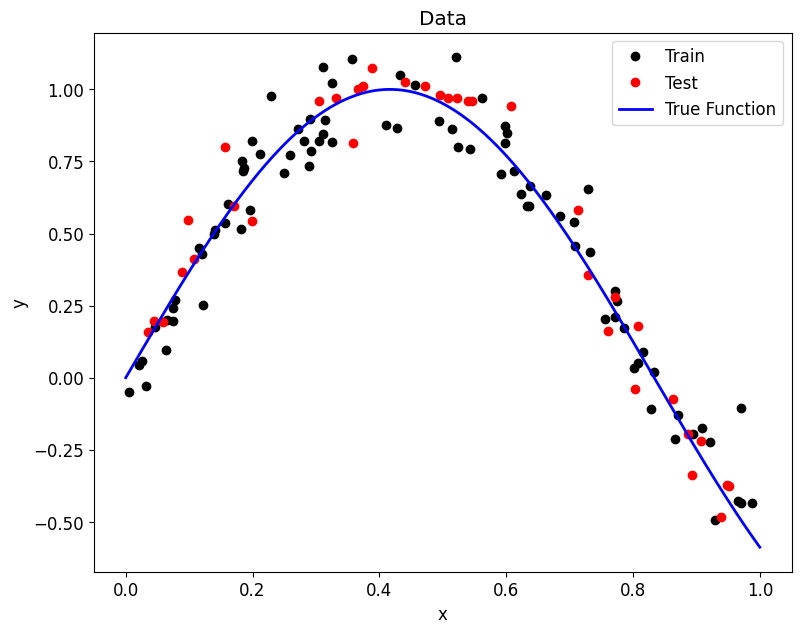

In [8]:
# Visualize observations and true curve
plt.plot(train, y_train, 'ko', label = 'Train');
plt.plot(test, y_test, 'ro', label = 'Test')
plt.plot(x_linspace, y_true, 'b-', linewidth = 2, label = 'True Function')

plt.legend()
plt.xlabel('x');
plt.ylabel('y');
plt.title('Data');

### Polynomial Model

$ y = w_0 + w_1x + x_2x^2 + ... +w_dx^d $
- d: 다항식의 차수
- w: 선형 회귀 가중치

다항회귀 모델
- 항이 여러 개인 가설 함수로 결과를 예측하는 회귀 모델
- 항은 제곱근이나 2차항, 3차항 등 다양하게 있으며 함수의 형태가 비선형이라는 특징이 있음


In [12]:
def fit_poly(train, y_train, test, y_test, degrees, plot='train', return_scores=False):

    # Create a polynomial transformation of features
    features = PolynomialFeatures(degree=degrees, include_bias=False)

    # Reshape training features for use in scikit-learn and transform features
    train = train.reshape((-1, 1))
    train_trans = features.fit_transform(train)

    # Create the linear regression model and train
    model = LinearRegression()
    model.fit(train_trans, y_train)

    # Calculate the cross validation score
    cross_valid = cross_val_score(model, train_trans, y_train, scoring='neg_mean_squared_error', cv = 5)

    # Training predictions and error
    train_predictions = model.predict(train_trans)
    training_error = mean_squared_error(y_train, train_predictions)

    # Format test features
    test = test.reshape((-1, 1))
    test_trans = features.fit_transform(test)

    # Test set predictions and error
    test_predictions = model.predict(test_trans)
    testing_error = mean_squared_error(y_test, test_predictions)

    # Find the model curve and the true curve
    x_curve = np.linspace(0, 1, 100)
    x_curve = x_curve.reshape((-1, 1))
    x_curve_trans = features.fit_transform(x_curve)

    # Model curve
    model_curve = model.predict(x_curve_trans)

    # True curve
    y_true_curve = true_gen(x_curve[:, 0])

    # Plot observations, true function, and model predicted function
    if plot == 'train':
        plt.plot(train[:, 0], y_train, 'ko', label = 'Observations')
        plt.plot(x_curve[:, 0], y_true_curve, linewidth = 4, label = 'True Function')
        plt.plot(x_curve[:, 0], model_curve, linewidth = 4, label = 'Model Function')
        plt.xlabel('x'); plt.ylabel('y')
        plt.legend()
        plt.ylim(-1, 1.5); plt.xlim(0, 1)
        plt.title('{} Degree Model on Training Data'.format(degrees))
        plt.show()

    elif plot == 'test':
        # Plot the test observations and test predictions
        plt.plot(test, y_test, 'o', label = 'Test Observations')
        plt.plot(x_curve[:, 0], y_true_curve, 'b-', linewidth = 2, label = 'True Function')
        plt.plot(test, test_predictions, 'ro', label = 'Test Predictions')
        plt.ylim(-1, 1.5); plt.xlim(0, 1)
        plt.legend(), plt.xlabel('x'), plt.ylabel('y'); plt.title('{} Degree Model on Testing Data'.format(degrees)), plt.show();

    # Return the metrics
    if return_scores:
        return training_error, testing_error, -np.mean(cross_valid)

## Underfitting

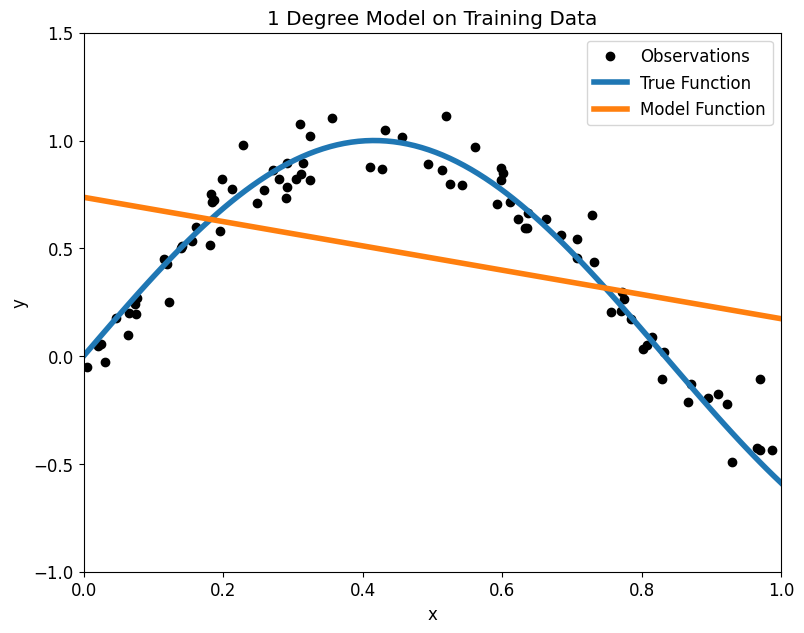

In [13]:
fit_poly(train, y_train, test, y_test, degrees = 1, plot='train')

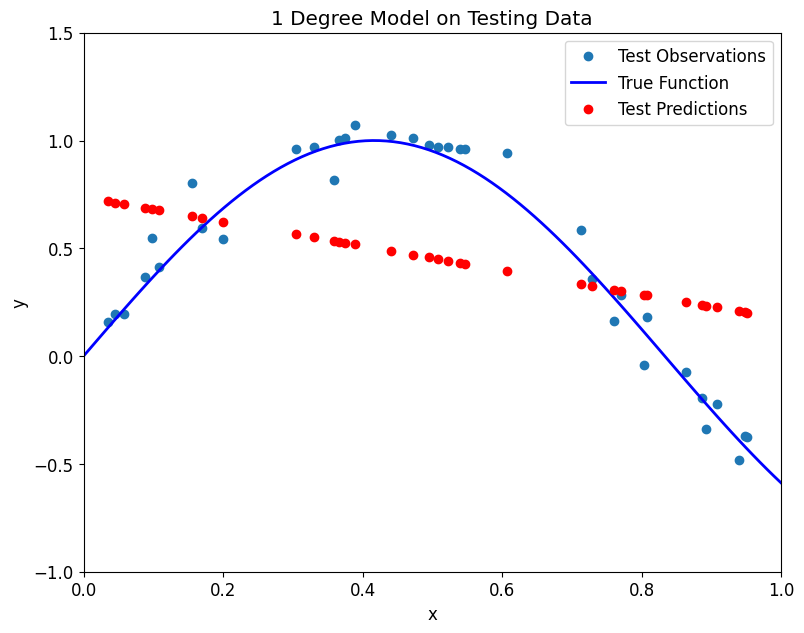

In [14]:
fit_poly(train, y_train, test, y_test, degrees = 1, plot='test')

## Overfitting

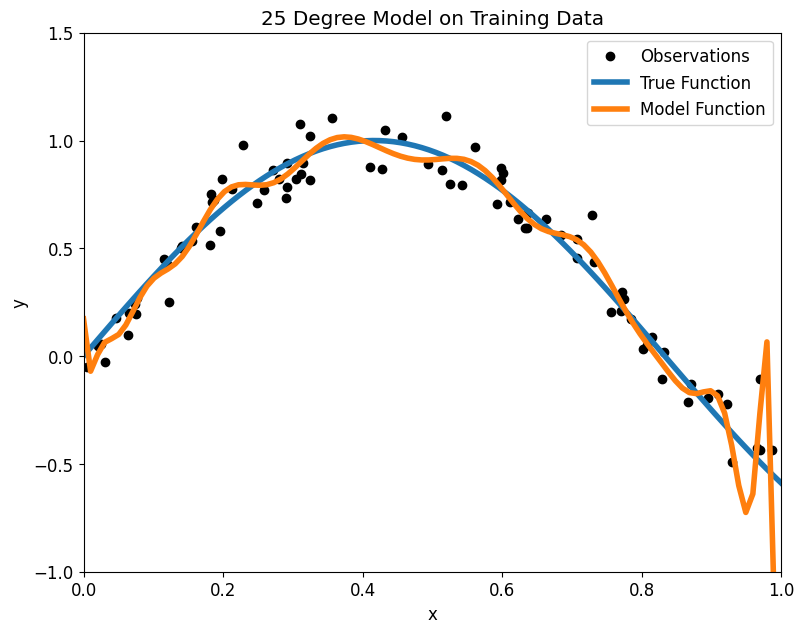

In [15]:
fit_poly(train, y_train, test, y_test, plot='train', degrees = 25)

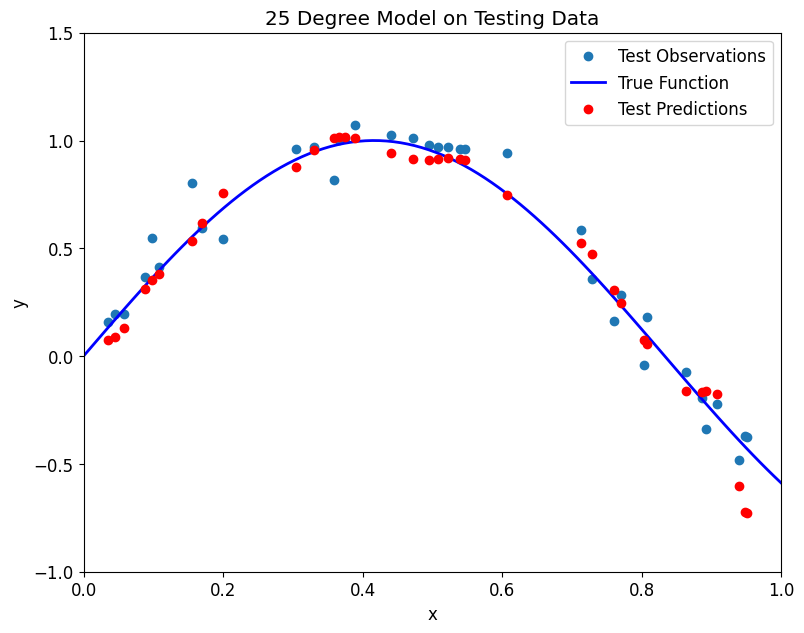

In [16]:
fit_poly(train, y_train, test, y_test, degrees=25, plot='test')

## Cross Validation

In [22]:
# Range of model degrees to evaluate
degrees = [int(x) for x in np.linspace(1, 40, 40)]

# Results dataframe
results = pd.DataFrame(0, columns = ['train_error', 'test_error', 'cross_valid'], index = degrees)

# Try each value of degrees for the model and record results
for degree in degrees:
    degree_results = fit_poly(train, y_train, test, y_test, degree, plot=False, return_scores=True)
    results.loc[degree, 'train_error'] = degree_results[0]
    results.loc[degree, 'test_error'] = degree_results[1]
    results.loc[degree, 'cross_valid'] = degree_results[2]

In [37]:
print('5 Lowest Cross Validation Errors\n')
train_eval = results.sort_values('cross_valid').reset_index(level=0).rename(columns={'index': 'degrees'})
train_eval.loc[:,['degrees', 'cross_valid']] .head(5)

5 Lowest Cross Validation Errors



,degrees,cross_valid
0,4,0.010549
1,5,0.010637
2,7,0.010665
3,6,0.010887
4,8,0.011182


In [27]:
results.head()

,train_error,test_error,cross_valid
1,0.146181,0.184781,0.153986
2,0.013589,0.012785,0.015078
3,0.010110,0.012551,0.011695
4,0.008974,0.010483,0.010549
5,0.008677,0.009482,0.010637


Minimum Cross Validation Error occurs at 4 degrees.



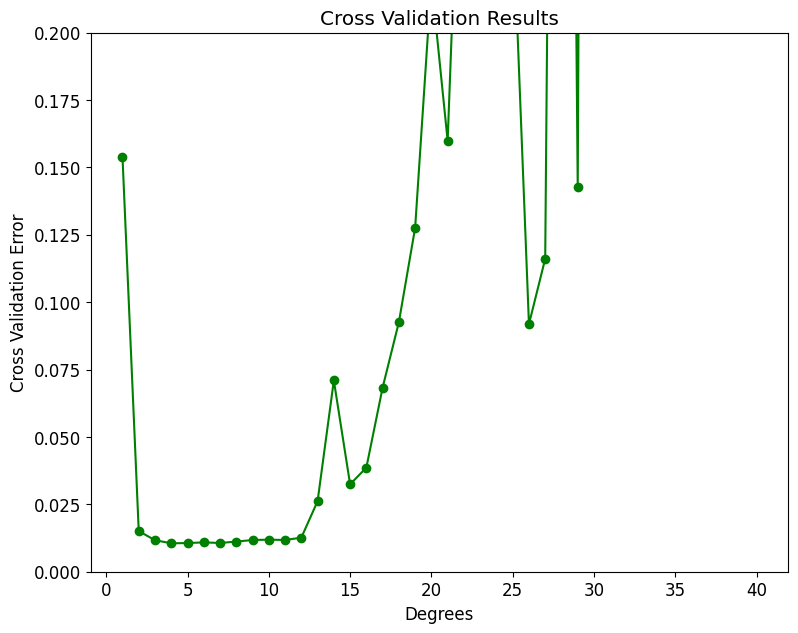

In [30]:
plt.plot(results.index, results['cross_valid'], 'go-', ms=6)
plt.xlabel('Degrees'); plt.ylabel('Cross Validation Error'); plt.title('Cross Validation Results');
plt.ylim(0, 0.2);
print('Minimum Cross Validation Error occurs at {} degrees.\n'.format(int(np.argmin(results['cross_valid']))+1))


### Best Model

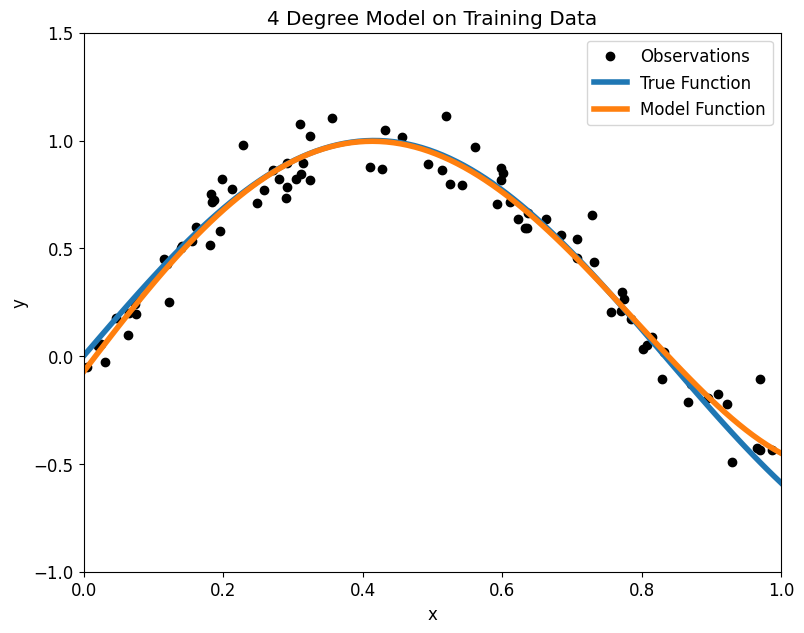

In [33]:
fit_poly(train, y_train, test, y_test, degrees=4, plot='train')

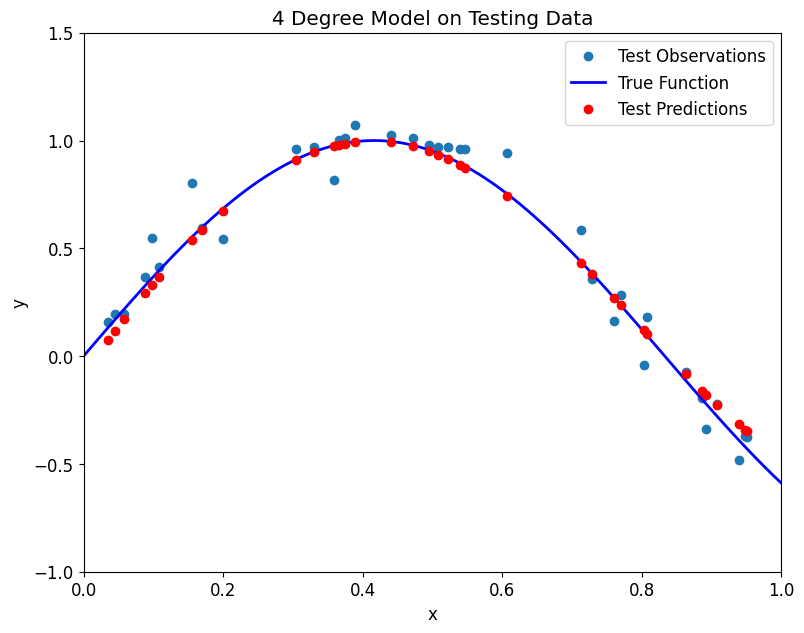

In [34]:
fit_poly(train, y_train, test, y_test, degrees=4, plot='test')

### Evaluate Models

In [36]:
print('5 Lowest Training Errors\n')
train_eval = results.sort_values('train_error').reset_index(level=0).rename(columns={'index': 'degrees'})
train_eval.loc[:,['degrees', 'train_error']] .head()

5 Lowest Training Errors



,degrees,train_error
0,36,0.006089
1,35,0.006137
2,40,0.006210
3,39,0.006261
4,31,0.006351


In [39]:
print('5 Lowest Testing Errors\n')
train_eval = results.sort_values('test_error').reset_index(level=0).rename(columns={'index': 'degrees'})
train_eval.loc[:,['degrees', 'test_error']] .head()

5 Lowest Testing Errors



,degrees,test_error
0,5,0.009482
1,6,0.010215
2,4,0.010483
3,8,0.010609
4,7,0.010618


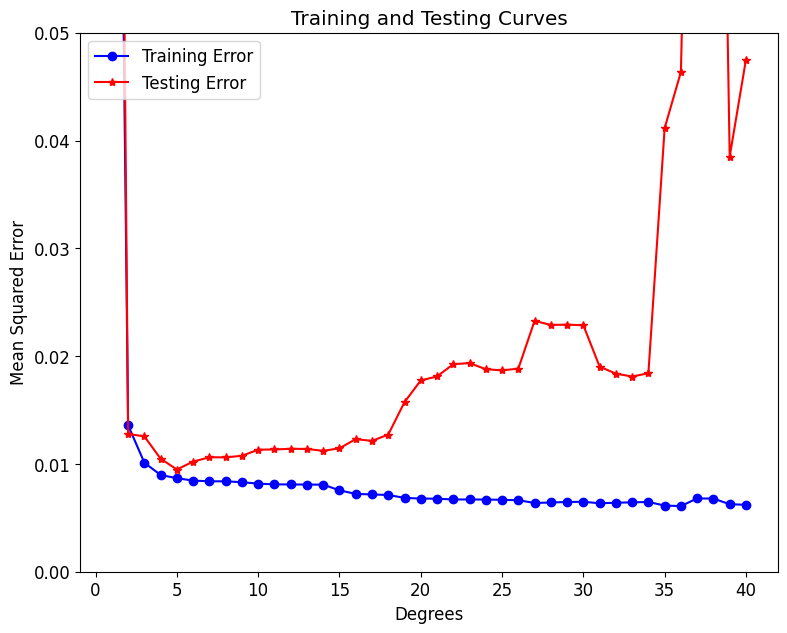


Minimum Training Error occurs at 36 degrees.
Minimum Testing Error occurs at 5 degrees.



In [41]:
plt.plot(results.index, results['train_error'], 'b-o', ms=6, label = 'Training Error')
plt.plot(results.index, results['test_error'], 'r-*', ms=6, label = 'Testing Error')
plt.legend(loc=2); plt.xlabel('Degrees'); plt.ylabel('Mean Squared Error'); plt.title('Training and Testing Curves');
plt.ylim(0, 0.05); plt.show()

print('\nMinimum Training Error occurs at {} degrees.'.format(int(np.argmin(results['train_error']))+1))
print('Minimum Testing Error occurs at {} degrees.\n'.format(int(np.argmin(results['test_error']))+1))